In [198]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt

import acquire

In [199]:
saas = pd.read_csv('saas.csv')
saas

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [200]:
saas.isnull().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [201]:
saas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [202]:
saas['Month_Invoiced'] = pd.to_datetime(saas['Month_Invoiced'])

In [203]:
saas = saas.set_index('Month_Invoiced')

In [204]:
saas = saas.drop(columns = ['Customer_Id', 'Invoice_Id', 'Subscription_Type'])

In [205]:
train_size = int(round(saas.shape[0] * 0.7))
validate_size = int(round(saas.shape[0] * 0.2))
test_size = int(round(saas.shape[0] * 0.1))

In [206]:
saas

,Amount
Month_Invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0
...,...
2017-12-31,0.0
2017-12-31,0.0
2017-12-31,15.0


In [207]:
train_size, validate_size, test_size

(553321, 158092, 79046)

In [208]:
validate_end_index = train_size + validate_size

In [209]:
train = saas[:train_size]
validate = saas[train_size:validate_end_index]
test = saas[validate_end_index:]

In [210]:
def time_series_subset(df):
    '''
    function that does what I did above
    '''
    train_size = int(round(df.shape[0] * 0.5))
    validate_size = int(round(df.shape[0] * 0.3))
    test_size = int(round(df.shape[0] * 0.2))
    
    print(train_size, validate_size, test_size)
    print(len(df) == train_size + validate_size + test_size)
    
    validate_end_index = train_size + validate_size
    
    train = df[:train_size]
    validate = df[train_size:validate_end_index]
    test = df[validate_end_index:]
    
    return train, validate, test

### Simple Average Forecast

In [211]:
train

,Amount
Month_Invoiced,
2014-01-31,0.0
2014-01-31,10.0
2014-01-31,0.0
2014-01-31,0.0
2014-01-31,5.0
...,...
2016-08-31,0.0
2016-08-31,0.0
2016-08-31,0.0


In [212]:
avg_sales = round(train['Amount'].mean(), 2)
avg_sales

2.71

In [213]:
yhat_df = pd.DataFrame({'Amount': [avg_sales]}, index = validate.index)

In [214]:
yhat_df

,Amount
Month_Invoiced,
2016-08-31,2.71
2016-08-31,2.71
2016-08-31,2.71
2016-08-31,2.71
2016-08-31,2.71
...,...
2017-07-31,2.71
2017-07-31,2.71
2017-07-31,2.71


<AxesSubplot:xlabel='Month_Invoiced'>

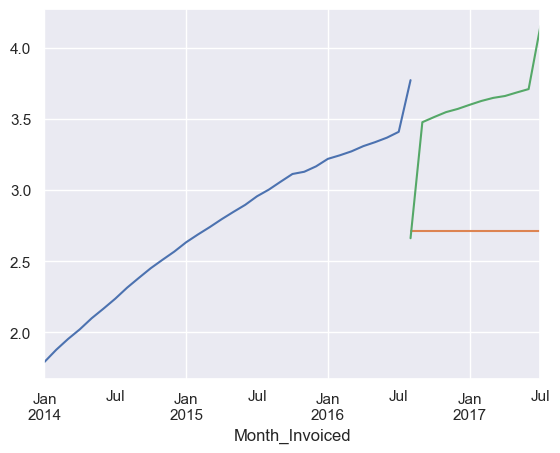

In [215]:
train.resample('M')['Amount'].mean().plot()
yhat_df.resample('M')['Amount'].mean().plot()
validate.resample('M')['Amount'].mean().plot()

In [216]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [217]:
evaluate('Amount')

5.0

In [218]:
evaluates = pd.DataFrame({'model_type' : ['Simple_Average'], 'RMSE' : [evaluate('Amount')]})

In [219]:
evaluates

,model_type,RMSE
0,Simple_Average,5.0


# Moving Average

In [220]:
period=30
rolling = round(train['Amount'].rolling(period).mean()[-1], 3)

In [221]:
yhat_df = yhat_df.assign(moving = rolling)

<AxesSubplot:xlabel='Month_Invoiced'>

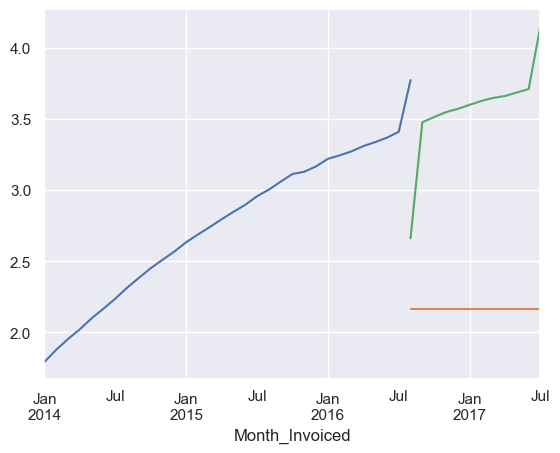

In [222]:
train.resample('M')['Amount'].mean().plot()
yhat_df.resample('M')['moving'].mean().plot()
validate.resample('M')['Amount'].mean().plot()

In [223]:
yhat_df

,Amount,moving
Month_Invoiced,,
2016-08-31,2.71,2.167
2016-08-31,2.71,2.167
2016-08-31,2.71,2.167
2016-08-31,2.71,2.167
2016-08-31,2.71,2.167
...,...,...
2017-07-31,2.71,2.167
2017-07-31,2.71,2.167
2017-07-31,2.71,2.167


In [224]:
rmse = round(sqrt(mean_squared_error(validate['Amount'], yhat_df['moving'])), 3)
rmse

5.199

In [225]:
rollings = pd.DataFrame({'model_type': ['Rolling_average'], 'RMSE': [rmse]})

In [226]:
rollings

,model_type,RMSE
0,Rolling_average,5.199


In [227]:
pd.concat([evaluates, rollings])

,model_type,RMSE
0,Simple_Average,5.000
0,Rolling_average,5.199


# Holt's model

In [228]:
model = Holt(train['Amount'], exponential=False, damped=True)


In [229]:
model = model.fit(optimized=True)

In [230]:
validate.index[-1]

Timestamp('2017-07-31 00:00:00')

In [231]:
validate.resample('M').mean()

,Amount
Month_Invoiced,
2016-08-31,2.661380
2016-09-30,3.476050
2016-10-31,3.512282
2016-11-30,3.546747
2016-12-31,3.569420
2017-01-31,3.598046
2017-02-28,3.625263
2017-03-31,3.646778
2017-04-30,3.660126


In [232]:
validate = validate.reset_index

In [234]:
validate

<bound method DataFrame.reset_index of                 Amount
Month_Invoiced        
2016-08-31        10.0
2016-08-31        15.0
2016-08-31         0.0
2016-08-31        10.0
2016-08-31         5.0
...                ...
2017-07-31         5.0
2017-07-31         5.0
2017-07-31        15.0
2017-07-31         0.0
2017-07-31         5.0

[158092 rows x 1 columns]>

In [236]:
yhat_sales_total = model.predict(validate)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [171]:
len(validate)

158092